In [39]:
# Import Statements

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torchvision.datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt



ModuleNotFoundError: ignored

In [2]:
# defining the function of displaying multiple images

def show_images(images) -> None:
  n: int = images.size(0)

  f = plt.figure(figsize=(24, 6))
  for i in range(n):
    # Debug, plot figure
    f.add_subplot(1, n, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')

  plt.show(block=True)

# defining the function of displaying multiple images

def show_images_withPred(images, label, pred, conf) -> None:
  n: int = images.size(0)

  f = plt.figure(figsize=(26, 6))
  for i in range (n):
    # Debug, plot figure
    f.add_subplot(1, n, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title("{} -> {}".format(label[i], pred[i]))
    plt.axis('off')

  plt.show(block=True)


In [3]:
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001

epsilons = [0, .05, .1, .15, .2, .25, .3]

use_cuda=True
DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)




  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
# neural network 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 20),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        out = self.classifier(x)

        return out


model=ConvNet()
model.cuda()
model.train()


ConvNet(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [5]:
from torchsummary import summary
summary(model, (1, 28, 28))

# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
            Linear-3                  [-1, 128]          16,512
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 32]           2,080
            Linear-6                   [-1, 20]             660
            Linear-7                   [-1, 10]             210
Total params: 128,198
Trainable params: 128,198
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.49
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [6]:
model.train()
loss_list = []
acc_list = []

total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


Epoch [1/10], Step [0/235], Loss: 2.3024, Accuracy: 7.42%
Epoch [1/10], Step [150/235], Loss: 0.3789, Accuracy: 89.84%
Epoch [2/10], Step [0/235], Loss: 0.3925, Accuracy: 90.23%
Epoch [2/10], Step [150/235], Loss: 0.4024, Accuracy: 89.45%
Epoch [3/10], Step [0/235], Loss: 0.3277, Accuracy: 92.97%
Epoch [3/10], Step [150/235], Loss: 0.4340, Accuracy: 89.06%
Epoch [4/10], Step [0/235], Loss: 0.3488, Accuracy: 89.06%
Epoch [4/10], Step [150/235], Loss: 0.2739, Accuracy: 92.58%
Epoch [5/10], Step [0/235], Loss: 0.2861, Accuracy: 93.75%
Epoch [5/10], Step [150/235], Loss: 0.3247, Accuracy: 92.97%
Epoch [6/10], Step [0/235], Loss: 0.4507, Accuracy: 87.50%
Epoch [6/10], Step [150/235], Loss: 0.3056, Accuracy: 89.84%
Epoch [7/10], Step [0/235], Loss: 0.2872, Accuracy: 91.02%
Epoch [7/10], Step [150/235], Loss: 0.4297, Accuracy: 89.84%
Epoch [8/10], Step [0/235], Loss: 0.2336, Accuracy: 93.75%
Epoch [8/10], Step [150/235], Loss: 0.3451, Accuracy: 90.62%
Epoch [9/10], Step [0/235], Loss: 0.2870,

In [7]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the DNN model on the 10000 test images: {} %'.format((correct / total) * 100))

Accuracy of the DNN model on the 10000 test images: 91.83 %


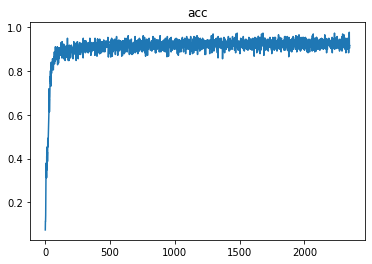

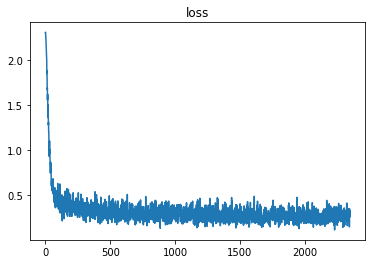

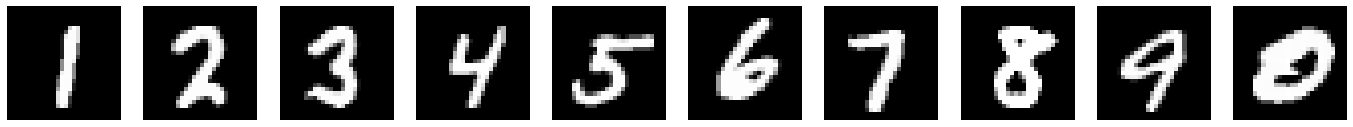

In [8]:
plt.figure()
plt.plot(acc_list)
plt.title('acc')

plt.figure()
plt.plot(loss_list)
plt.title('loss')

show_images(images[:10])

In [ ]:
#show_images(images[:12])


Incorrect Predictions:


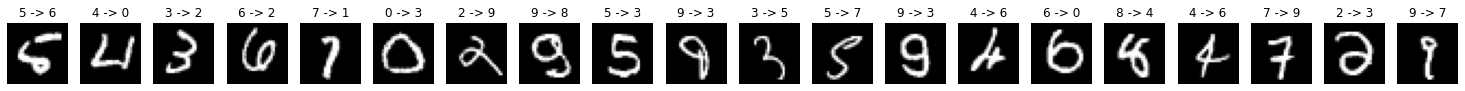

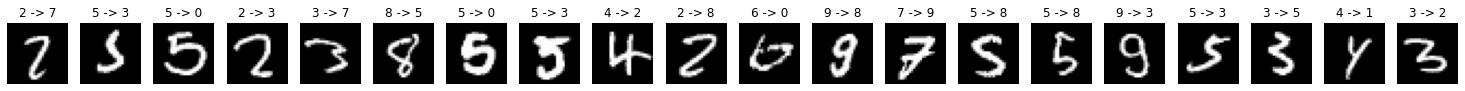

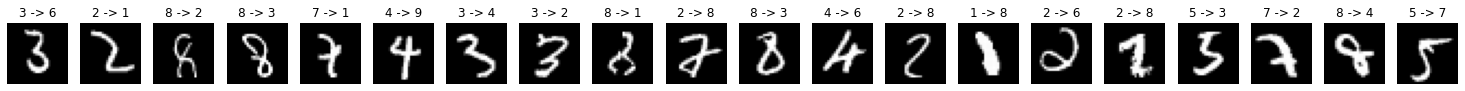

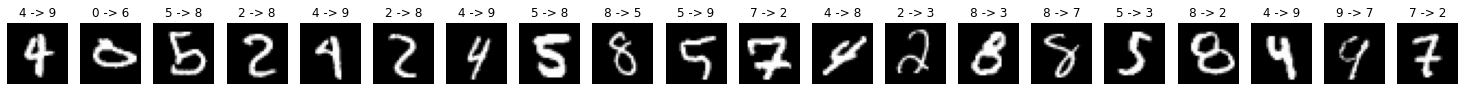


 
 Correct Predictions:


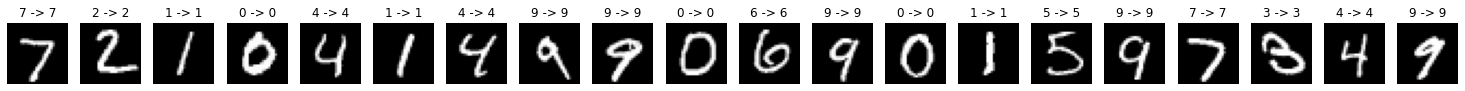

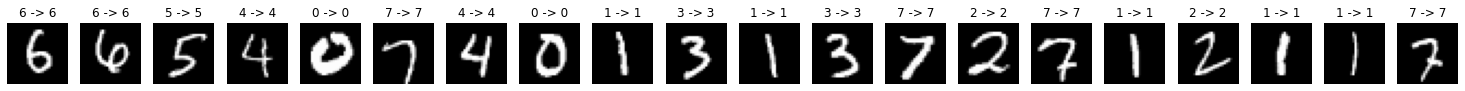

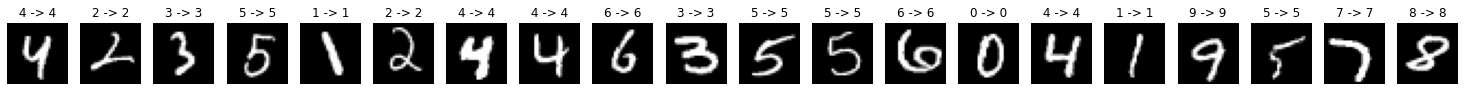

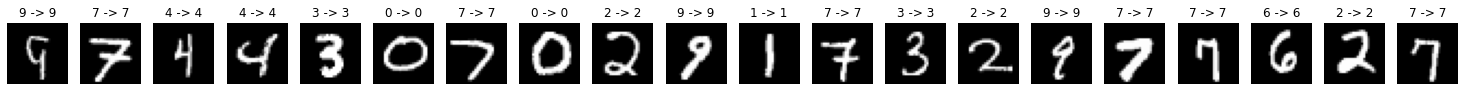

In [9]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for i, (images, labels) in enumerate(test_loader):
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      confidences = outputs.softmax(1)
      _, predicted = torch.max(outputs.data, 1)
      correct_idx = predicted == labels
      incorrect_idx = predicted != labels
      
      if i == 0:
        correct_images, correct_labels, correct_pred, correct_conf = images[correct_idx], labels[correct_idx], predicted[correct_idx], confidences[correct_idx]
        incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf = images[incorrect_idx], labels[incorrect_idx], predicted[incorrect_idx], confidences[incorrect_idx]
      else:
        correct_images, correct_labels, correct_pred, correct_conf = torch.cat((correct_images, images[correct_idx]),0), torch.cat((correct_labels, labels[correct_idx]),0), torch.cat((correct_pred, predicted[correct_idx]),0), torch.cat((correct_conf, confidences[correct_idx]),0)
        incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf = torch.cat((incorrect_images, images[incorrect_idx]),0), torch.cat((incorrect_labels, labels[incorrect_idx]),0), torch.cat((incorrect_pred, predicted[incorrect_idx]),0), torch.cat((incorrect_conf, confidences[incorrect_idx]),0)

print("Incorrect Predictions:")
plt_num = 20
for i in range(4):
  show_images_withPred(incorrect_images[i*plt_num:(i+1)*plt_num], incorrect_labels[i*plt_num:(i+1)*plt_num],incorrect_pred[i*plt_num:(i+1)*plt_num], correct_conf[i*plt_num:(i+1)*plt_num])

print("\n \n Correct Predictions:")
for i in range(4):
  show_images_withPred(correct_images[i*plt_num:(i+1)*plt_num], correct_labels[i*plt_num:(i+1)*plt_num],correct_pred[i*plt_num:(i+1)*plt_num], incorrect_conf[i*plt_num:(i+1)*plt_num])

del correct_images, correct_labels,correct_pred,correct_conf,incorrect_images,incorrect_labels,incorrect_pred,incorrect_conf

In [10]:
# DCNN

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
            nn.Linear(7 * 7 * 16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(84, 10)
            
    def forward(self, x):
        out = self.features(x)
        out = self.fc3(out)

        return out


# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = LeNet().to(device)
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from torchsummary import summary
summary(model, (1, 28, 28))

CUDA Available:  True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         MaxPool2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           3,216
              ReLU-6           [-1, 16, 14, 14]               0
       BatchNorm2d-7           [-1, 16, 14, 14]              32
         MaxPool2d-8             [-1, 16, 7, 7]               0
           Flatten-9                  [-1, 784]               0
           Linear-10                  [-1, 120]          94,200
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
             ReLU-13                   [-1, 84]               0
           Linear

In [11]:
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the DCNN model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/10], Step [0/235], Loss: 2.3126, Accuracy: 14.84%
Epoch [1/10], Step [150/235], Loss: 0.0779, Accuracy: 98.05%
Epoch [2/10], Step [0/235], Loss: 0.0722, Accuracy: 98.05%
Epoch [2/10], Step [150/235], Loss: 0.0136, Accuracy: 99.61%
Epoch [3/10], Step [0/235], Loss: 0.0120, Accuracy: 99.61%
Epoch [3/10], Step [150/235], Loss: 0.0234, Accuracy: 98.83%
Epoch [4/10], Step [0/235], Loss: 0.0107, Accuracy: 100.00%
Epoch [4/10], Step [150/235], Loss: 0.0262, Accuracy: 98.83%
Epoch [5/10], Step [0/235], Loss: 0.0428, Accuracy: 98.05%
Epoch [5/10], Step [150/235], Loss: 0.0111, Accuracy: 99.61%
Epoch [6/10], Step [0/235], Loss: 0.0268, Accuracy: 98.83%
Epoch [6/10], Step [150/235], Loss: 0.0151, Accuracy: 99.61%
Epoch [7/10], Step [0/235], Loss: 0.0019, Accuracy: 100.00%
Epoch [7/10], Step [150/235], Loss: 0.0089, Accuracy: 99.61%
Epoch [8/10], Step [0/235], Loss: 0.0080, Accuracy: 99.61%
Epoch [8/10], Step [150/235], Loss: 0.0012, Accuracy: 100.00%
Epoch [9/10], Step [0/235], Loss: 0.0

Incorrect Predictions:


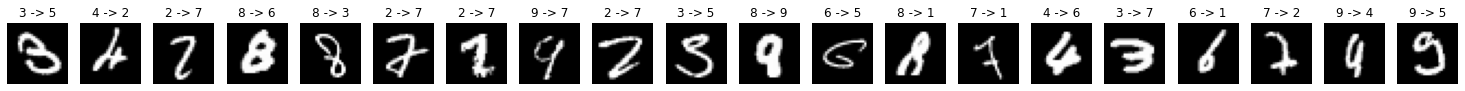

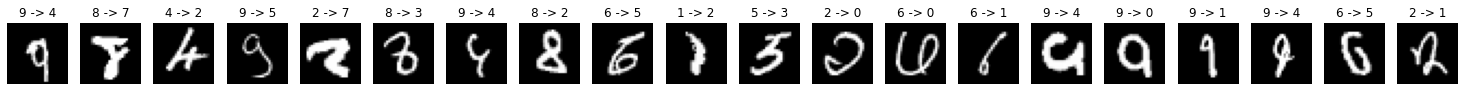

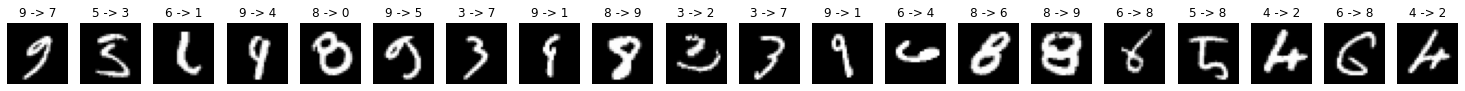

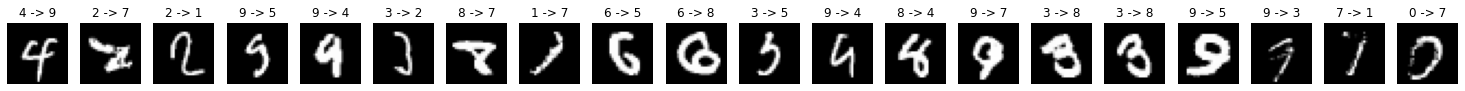


 
 Correct Predictions:


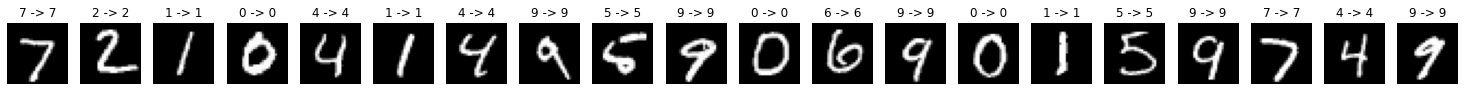

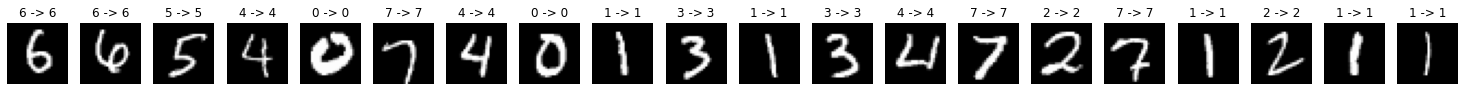

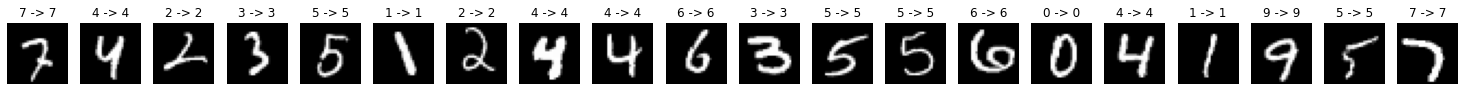

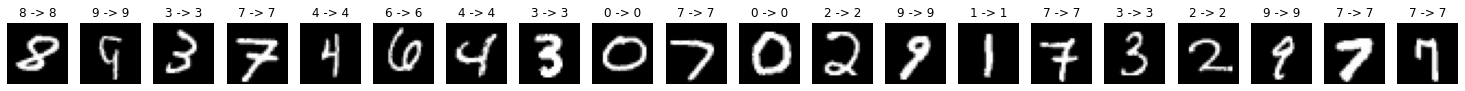

In [12]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for i, (images, labels) in enumerate(test_loader):
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      confidences = outputs.softmax(1)
      _, predicted = torch.max(outputs.data, 1)
      correct_idx = predicted == labels
      incorrect_idx = predicted != labels
      
      if i == 0:
        correct_images, correct_labels, correct_pred, correct_conf = images[correct_idx], labels[correct_idx], predicted[correct_idx], confidences[correct_idx]
        incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf = images[incorrect_idx], labels[incorrect_idx], predicted[incorrect_idx], confidences[incorrect_idx]
      else:
        correct_images, correct_labels, correct_pred, correct_conf = torch.cat((correct_images, images[correct_idx]),0), torch.cat((correct_labels, labels[correct_idx]),0), torch.cat((correct_pred, predicted[correct_idx]),0), torch.cat((correct_conf, confidences[correct_idx]),0)
        incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf = torch.cat((incorrect_images, images[incorrect_idx]),0), torch.cat((incorrect_labels, labels[incorrect_idx]),0), torch.cat((incorrect_pred, predicted[incorrect_idx]),0), torch.cat((incorrect_conf, confidences[incorrect_idx]),0)

print("Incorrect Predictions:")
plt_num = 20
for i in range(4):
  show_images_withPred(incorrect_images[i*plt_num:(i+1)*plt_num], incorrect_labels[i*plt_num:(i+1)*plt_num],incorrect_pred[i*plt_num:(i+1)*plt_num], correct_conf[i*plt_num:(i+1)*plt_num])

print("\n \n Correct Predictions:")
for i in range(4):
  show_images_withPred(correct_images[i*plt_num:(i+1)*plt_num], correct_labels[i*plt_num:(i+1)*plt_num],correct_pred[i*plt_num:(i+1)*plt_num], incorrect_conf[i*plt_num:(i+1)*plt_num])

del correct_images, correct_labels,correct_pred,correct_conf,incorrect_images,incorrect_labels,incorrect_pred,incorrect_conf

Text(0.5, 1.0, 'loss')

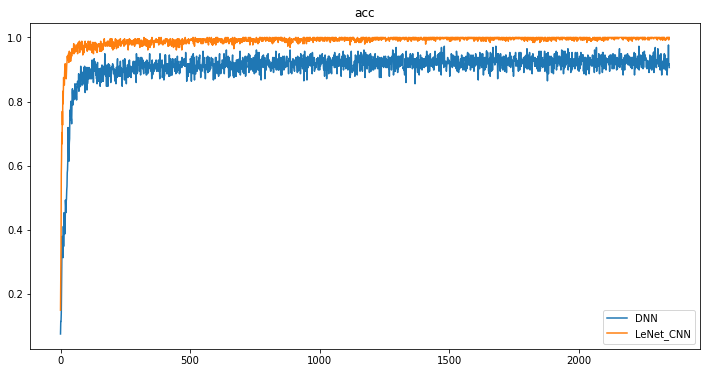

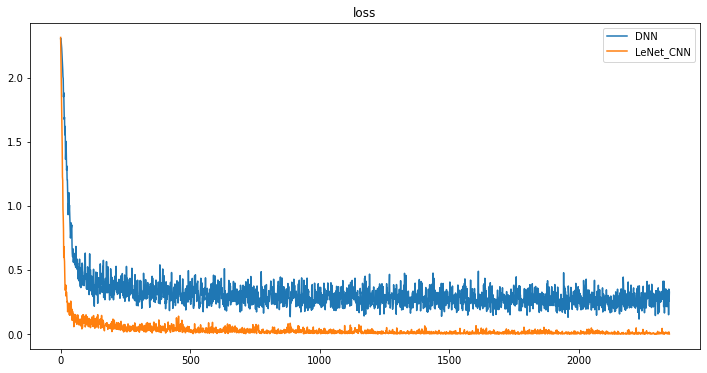

In [13]:
plt.figure(figsize=(12,6))
plt.plot(acc_list)
plt.plot(acc_list_cnn)
plt.legend(['DNN','LeNet_CNN'])
plt.title('acc')

plt.figure(figsize=(12,6))
plt.plot(loss_list)
plt.plot(loss_list_cnn)
plt.legend(['DNN','LeNet_CNN'])
plt.title('loss')

In [17]:
# Applying FGSM Attack
    
def fgsm_attack(images, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = images + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [80]:
#Testing the function:

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    total = 0
    data, target = next(iter(test_loader))
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        init_pred_ = init_pred.reshape(256)
        init_pred_ = init_pred_.cpu().data.numpy().argmax()
        target_ = target.cpu().data.numpy().argmax()
        #print(init_pred)
        #print(init_pred_)
        #print(init_pred.size())
        #print(target.size())
        #print(target)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred_.item() != target_.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred_ = final_pred.cpu().data.numpy().argmax()
        if final_pred_.item() == target_.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred_.item(), final_pred_.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred_.item(), final_pred_.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [81]:
# Run attack
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

ValueError: ignored

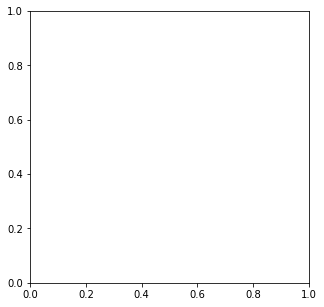

In [16]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Accuracy of the model on the test images: 40.234375 %


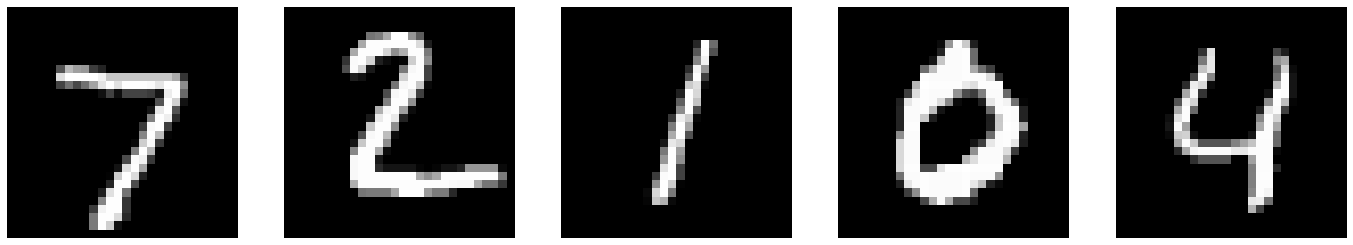

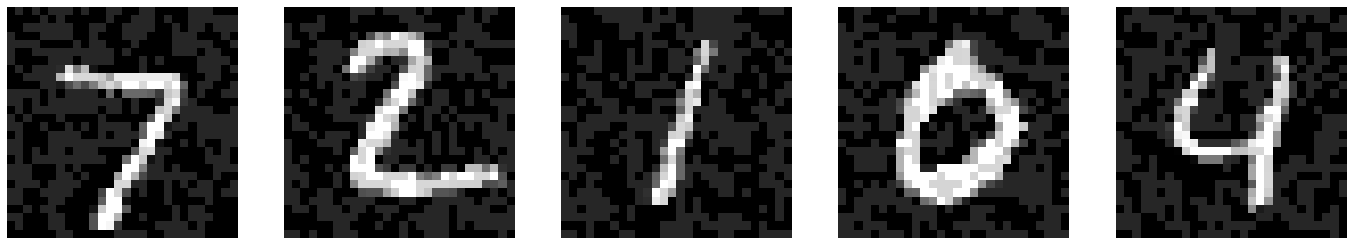

In [ ]:
def ae_attack(model, criterion, images, labels, step_size) : 
    images.requires_grad = True
    outputs = model(images)
    
    model.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    
    ae_images = images + step_size*images.grad.sign()
    #print(images.grad[0][0])
    #show_images(images.grad.sign()[:5])
    ae_images = torch.clamp(ae_images, 0, 1)
    
    return ae_images



model.eval()

correct = 0
total = 0
images, labels = next(iter(test_loader))
images = images.cuda()
labels = labels.cuda()
ae_images = ae_attack(model, criterion, images, labels, step_size=0.15)

outputs = model(ae_images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the test images: {} %'.format((correct / total) * 100))


show_images(images[:5].detach())
show_images(ae_images[:5].detach())

Accuracy of the model on the test images: 96.484375 %


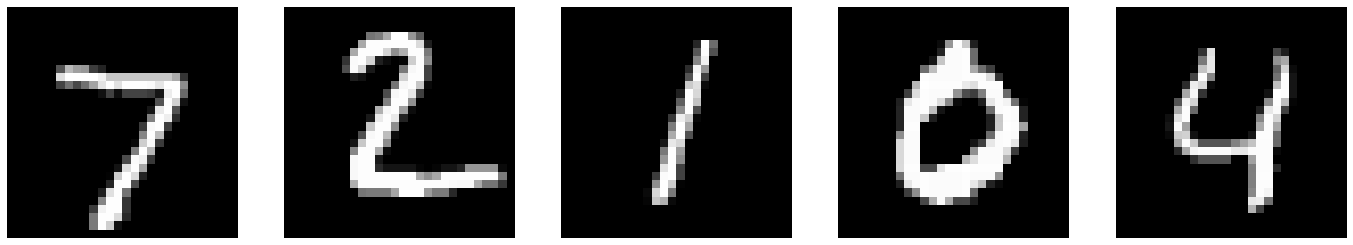

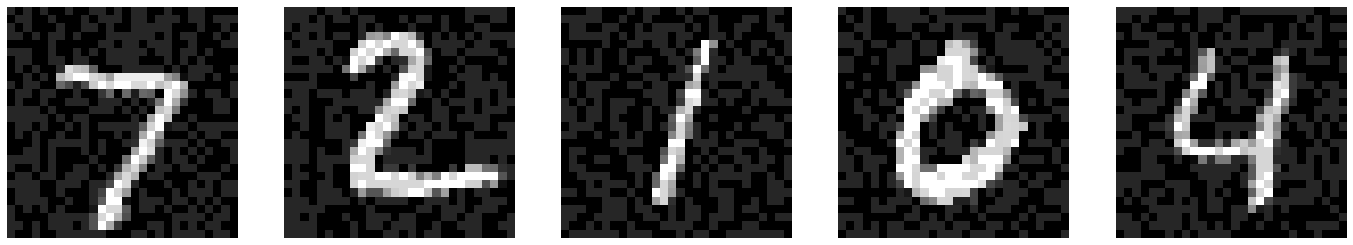

In [ ]:
#Random noise injection

def rand_noise_attack(images, step_size) : 
    rand_perturbation = torch.randn_like(images)
    ae_images = images + step_size*rand_perturbation.sign()
    #show_images(rand_perturbation.sign()[:5])
    ae_images = torch.clamp(ae_images, 0, 1)
    
    return ae_images

model.eval()
correct = 0
total = 0
images, labels = next(iter(test_loader))
images = images.cuda()
labels = labels.cuda()
ae_images = rand_noise_attack(images,step_size=0.15)

outputs = model(ae_images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

show_images(images[:5].detach())
show_images(ae_images[:5].detach())

In [ ]:
# Model B, ideal case, the attacker has the knowledge of the model A's architecture.

class Attacker_Model(nn.Module):
    def __init__(self):
        super(Attacker_Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
            
    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model_B=Attacker_Model()
model_B.cuda()
model_B.train()


# Assume the attacker has a smaller dataset (5000 images).
from torch.utils.data import Subset

tempid = torch.range(0, 5000,dtype=torch.int)
train_dataset_attacker = Subset(train_dataset, tempid)
# Data loader
train_loader_attacker = DataLoader(dataset=train_dataset_attacker, batch_size=batch_size, num_workers=4, shuffle=True)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_attacker = torch.optim.Adam(model_B.parameters(), lr=learning_rate)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


In [ ]:
# Train model B 
model_B.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader_attacker)

for epoch in range(40):
  for i, (images, labels) in enumerate(train_loader_attacker):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model_B(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer_attacker.zero_grad()
    loss.backward()
    optimizer_attacker.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      

model_B.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model_B(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/50], Step [0/20], Loss: 2.2991, Accuracy: 12.11%
Epoch [2/50], Step [0/20], Loss: 1.1525, Accuracy: 70.31%
Epoch [3/50], Step [0/20], Loss: 0.3553, Accuracy: 91.41%
Epoch [4/50], Step [0/20], Loss: 0.3316, Accuracy: 90.23%
Epoch [5/50], Step [0/20], Loss: 0.1601, Accuracy: 94.53%
Epoch [6/50], Step [0/20], Loss: 0.1545, Accuracy: 94.92%
Epoch [7/50], Step [0/20], Loss: 0.1388, Accuracy: 96.09%
Epoch [8/50], Step [0/20], Loss: 0.1804, Accuracy: 96.09%
Epoch [9/50], Step [0/20], Loss: 0.1241, Accuracy: 95.31%
Epoch [10/50], Step [0/20], Loss: 0.1041, Accuracy: 96.88%
Epoch [11/50], Step [0/20], Loss: 0.0548, Accuracy: 98.05%
Epoch [12/50], Step [0/20], Loss: 0.0574, Accuracy: 98.44%
Epoch [13/50], Step [0/20], Loss: 0.0305, Accuracy: 99.61%
Epoch [14/50], Step [0/20], Loss: 0.0316, Accuracy: 99.22%
Epoch [15/50], Step [0/20], Loss: 0.0348, Accuracy: 99.61%
Epoch [16/50], Step [0/20], Loss: 0.0391, Accuracy: 99.22%
Epoch [17/50], Step [0/20], Loss: 0.0364, Accuracy: 99.22%
Epoch 

Accuracy of the model_B on the 10000 test images: 24.8 %
Accuracy of the model on the 10000 test images: 87.22 %


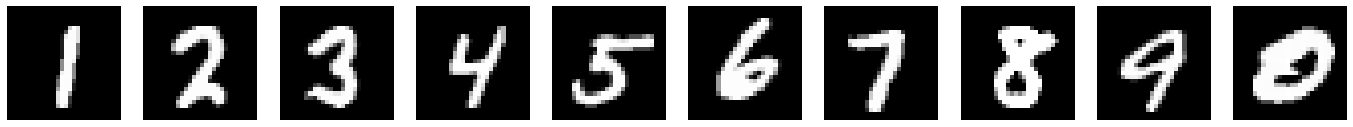

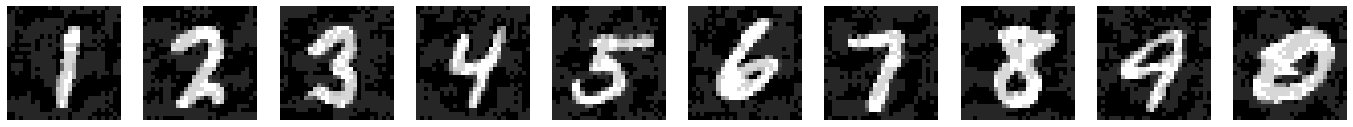

In [ ]:
# Generating AE on model_B 
model.eval()
model_B.eval()

correct = 0
total = 0

correct_B = 0
total_B = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    #generate AEs on model B
    ae_images = ae_attack(model_B, criterion, images, labels, step_size=0.15)

    #compute local accuracy on model B
    outputs = model_B(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total_B += labels.size(0)
    correct_B += (predicted == labels).sum().item()

    #compute accuracy on model A
    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct_B / total_B) * 100))

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images[:10].detach())

In [ ]:
# Model B, ideal case, the attacker has the knowledge of the model A's architecture.
# Testing Model_B with the original model

model_B=Attacker_Model()
model_B.cuda()
model_B.train()
model.train()

# Loss and optimizer
def distillation(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


optimizer_attacker = torch.optim.Adam(model_B.parameters(), lr=learning_rate)

# Train model B 
model_B.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader_attacker)

for epoch in range(30):
  for i, (images, labels) in enumerate(train_loader_attacker):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model_B(images)

    # acquire the soft label of the victim model
    with torch.no_grad():
      soft_label = model(images)
    loss = distillation(outputs, labels, soft_label, T=20.0, alpha=0.7)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer_attacker.zero_grad()
    loss.backward()
    optimizer_attacker.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      

model_B.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model_B(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct / total) * 100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Epoch [1/50], Step [0/20], Loss: 40.0360, Accuracy: 16.02%
Epoch [2/50], Step [0/20], Loss: 34.0153, Accuracy: 53.52%
Epoch [3/50], Step [0/20], Loss: 19.1112, Accuracy: 75.00%
Epoch [4/50], Step [0/20], Loss: 12.9657, Accuracy: 82.03%
Epoch [5/50], Step [0/20], Loss: 12.0210, Accuracy: 83.59%
Epoch [6/50], Step [0/20], Loss: 9.5188, Accuracy: 86.33%
Epoch [7/50], Step [0/20], Loss: 7.7111, Accuracy: 91.02%
Epoch [8/50], Step [0/20], Loss: 7.4656, Accuracy: 91.02%
Epoch [9/50], Step [0/20], Loss: 6.2246, Accuracy: 94.53%
Epoch [10/50], Step [0/20], Loss: 6.1751, Accuracy: 95.31%
Epoch [11/50], Step [0/20], Loss: 5.5526, Accuracy: 94.14%
Epoch [12/50], Step [0/20], Loss: 4.9832, Accuracy: 94.14%
Epoch [13/50], Step [0/20], Loss: 4.6204, Accuracy: 95.70%
Epoch [14/50], Step [0/20], Loss: 4.6257, Accuracy: 94.92%
Epoch [15/50], Step [0/20], Loss: 3.7207, Accuracy: 97.66%
Epoch [16/50], Step [0/20], Loss: 3.7300, Accuracy: 97.27%
Epoch [17/50], Step [0/20], Loss: 3.5165, Accuracy: 97.27%
E

Accuracy of the model_B on the 10000 test images: 40.6 %
Accuracy of the model on the 10000 test images: 90.53 %


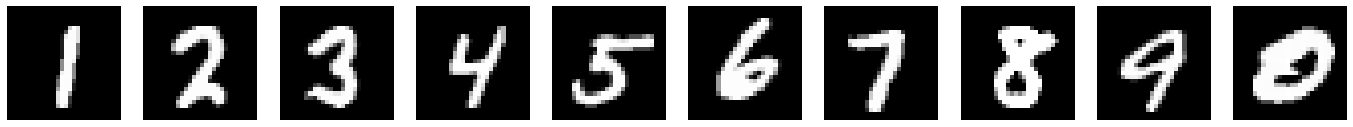

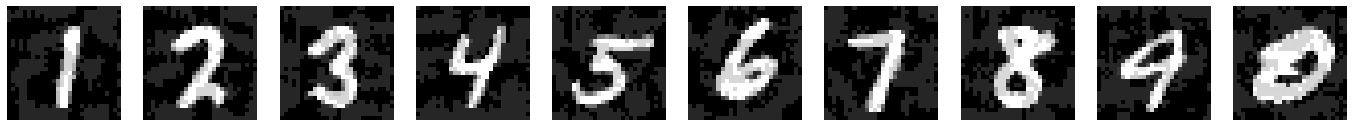

In [ ]:
model.eval()
model_B.eval()

correct = 0
total = 0

correct_B = 0
total_B = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    #generate AEs on model B
    ae_images = ae_attack(model_B, criterion, images, labels, step_size=0.15)

    #compute local accuracy on model B
    outputs = model_B(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total_B += labels.size(0)
    correct_B += (predicted == labels).sum().item()

    #compute accuracy on model A
    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct_B / total_B) * 100))

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images[:10].detach())

In [ ]:
class Attacker_Model(nn.Module):
    def __init__(self):
        super(Attacker_Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 6, 100)
        self.fc2 = nn.Linear(100, 32)
        self.fc3 = nn.Linear(32, 10)
            
    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

# Model B, ideal case, the attacker has the knowledge of the model A's architecture.

model_B=Attacker_Model()
model_B.cuda()
model_B.train()
model.train()


# Loss and optimizer
def distillation(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


optimizer_attacker = torch.optim.Adam(model_B.parameters(), lr=learning_rate)



# Train model B 
model_B.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader_attacker)

for epoch in range(30):
  for i, (images, labels) in enumerate(train_loader_attacker):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model_B(images)

    # acquire the soft label of the victim model
    with torch.no_grad():
      soft_label = model(images)
    loss = distillation(outputs, labels, soft_label, T=20.0, alpha=0.8)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer_attacker.zero_grad()
    loss.backward()
    optimizer_attacker.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      

model_B.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model_B(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct / total) * 100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50], Step [0/20], Loss: 46.3313, Accuracy: 8.98%
Epoch [2/50], Step [0/20], Loss: 45.4566, Accuracy: 17.19%
Epoch [3/50], Step [0/20], Loss: 38.6594, Accuracy: 46.88%
Epoch [4/50], Step [0/20], Loss: 25.6786, Accuracy: 66.80%
Epoch [5/50], Step [0/20], Loss: 17.1365, Accuracy: 77.73%
Epoch [6/50], Step [0/20], Loss: 14.2066, Accuracy: 79.30%
Epoch [7/50], Step [0/20], Loss: 11.5565, Accuracy: 85.94%
Epoch [8/50], Step [0/20], Loss: 9.7125, Accuracy: 90.62%
Epoch [9/50], Step [0/20], Loss: 9.3829, Accuracy: 90.23%
Epoch [10/50], Step [0/20], Loss: 9.6201, Accuracy: 89.45%
Epoch [11/50], Step [0/20], Loss: 8.2019, Accuracy: 91.02%
Epoch [12/50], Step [0/20], Loss: 8.4681, Accuracy: 91.02%
Epoch [13/50], Step [0/20], Loss: 6.9775, Accuracy: 93.36%
Epoch [14/50], Step [0/20], Loss: 7.1462, Accuracy: 93.75%
Epoch [15/50], Step [0/20], Loss: 6.6261, Accuracy: 92.58%
Epoch [16/50], Step [0/20], Loss: 5.9702, Accuracy: 93.36%
Epoch [17/50], Step [0/20], Loss: 6.2402, Accuracy: 95.31%


Accuracy of the model_B on the 10000 test images: 34.97 %
Accuracy of the model on the 10000 test images: 93.82000000000001 %


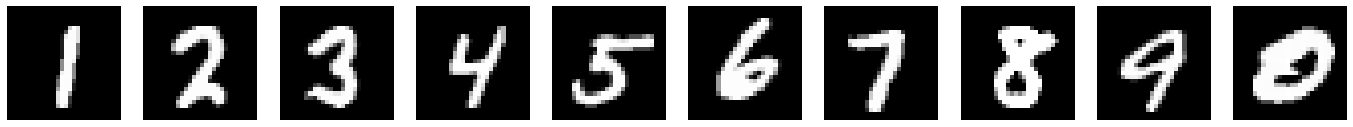

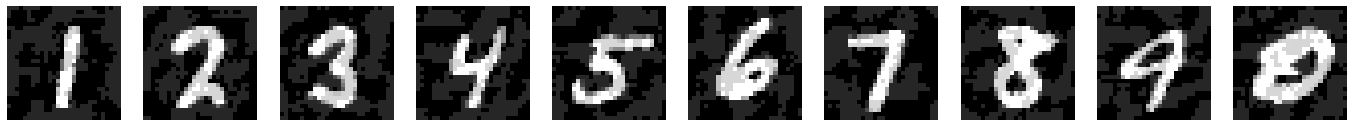

In [ ]:
model.eval()
model_B.eval()

correct = 0
total = 0

correct_B = 0
total_B = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    #generate AEs on model B
    ae_images = ae_attack(model_B, criterion, images, labels, step_size=0.15)

    #compute local accuracy on model B
    outputs = model_B(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total_B += labels.size(0)
    correct_B += (predicted == labels).sum().item()

    #compute accuracy on model A
    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct_B / total_B) * 100))

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images[:10].detach())

Accuracy of the model_B on the 10000 test images: 34.97 %
Accuracy of the model on the 10000 test images: 91.155 %


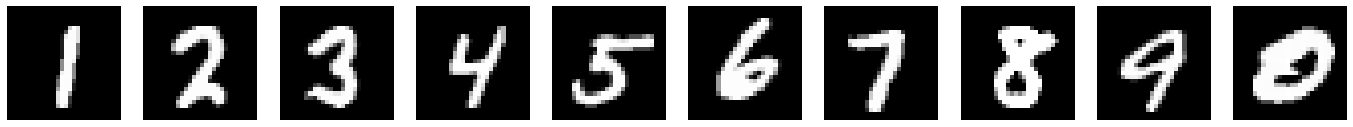

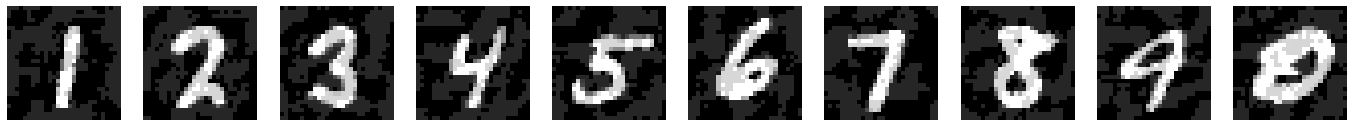

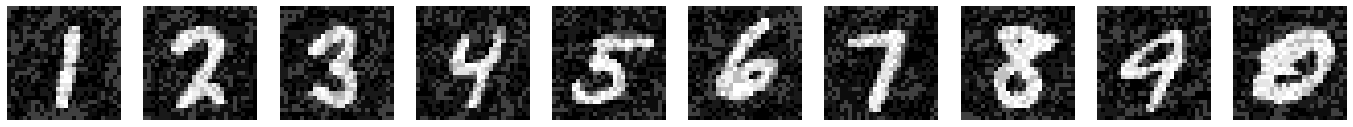

In [ ]:
#Defense #1, inject random patterns to disrupt the adversarial perturbation.

model.eval()
model_B.eval()

correct = 0
total = 0

correct_B = 0
total_B = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    #generate AEs on model B
    ae_images = ae_attack(model_B, criterion, images, labels, step_size=0.15)

    #compute local accuracy on model B
    outputs = model_B(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total_B += labels.size(0)
    correct_B += (predicted == labels).sum().item()

    #compute accuracy on model A
    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    #compute accuracy on model A with defense
    ae_images_afterD = rand_noise_attack(ae_images,step_size=0.1)
    outputs = model(ae_images_afterD)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct_B / total_B) * 100))

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images[:10].detach())
show_images(ae_images_afterD[:10].detach())

Accuracy of the model_B on the 10000 test images: 85.58 %
Accuracy of the model on the 10000 test images: 95.77 %


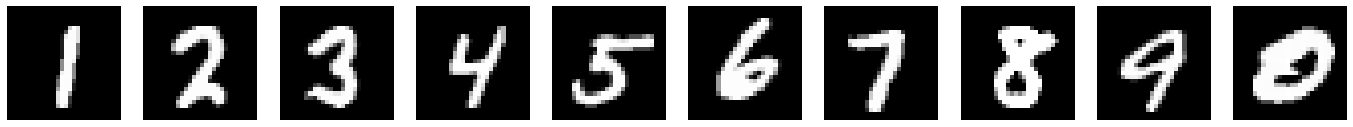

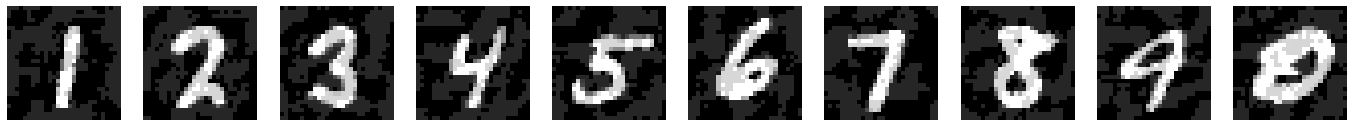

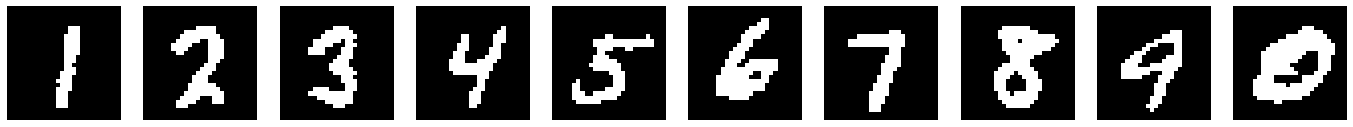

In [ ]:
#Defense #2, convert input images to binary images.
def binary_img(images) : 
    idx = images <0.55
    idx_2 = images >=0.55
    images[idx] =0
    images[idx_2] =1

    return images


model.eval()
model_B.eval()

correct = 0
total = 0

correct_B = 0
total_B = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    #generate AEs on model B
    ae_images = ae_attack(model_B, criterion, images, labels, step_size=0.15)

    #compute local accuracy on model B
    ae_images_b = binary_img(ae_images.clone())
    outputs = model_B(ae_images_b)
    _, predicted = torch.max(outputs.data, 1)
    total_B += labels.size(0)
    correct_B += (predicted == labels).sum().item()

    #compute accuracy on model A
    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    #compute accuracy on model A with defense
    ae_images_afterD = binary_img(ae_images.clone())
    outputs = model(ae_images_afterD)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct_B / total_B) * 100))

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images[:10].detach())
show_images(ae_images_afterD[:10].detach())

Accuracy of the model_B on the 10000 test images: 85.58 %
Accuracy of the model on the 10000 test images: 95.7 %


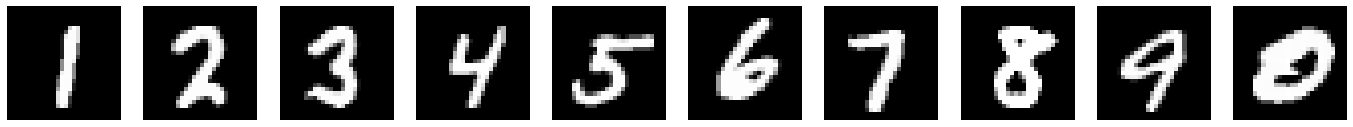

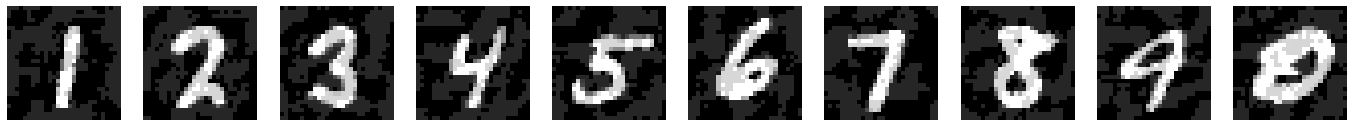

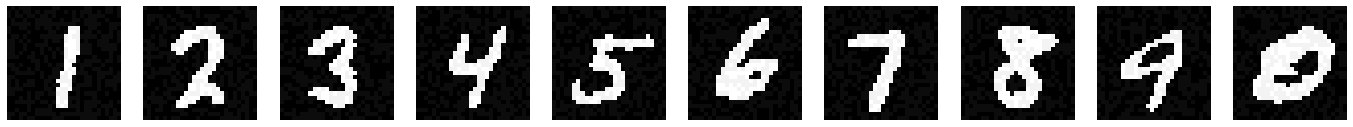

In [ ]:
#Defense #3, combine defense #1 and #2
def binary_img(images) : 
    idx = images <0.55
    idx_2 = images >=0.55
    temp_imgs = images.clone()
    temp_imgs[idx] =0
    temp_imgs[idx_2] =1

    return temp_imgs


model.eval()
model_B.eval()

correct = 0
total = 0

correct_B = 0
total_B = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    #generate AEs on model B
    ae_images = ae_attack(model_B, criterion, images, labels, step_size=0.15)

    #compute local accuracy on model B
    ae_images_b = binary_img(ae_images.clone())
    outputs = model_B(ae_images_b)
    _, predicted = torch.max(outputs.data, 1)
    total_B += labels.size(0)
    correct_B += (predicted == labels).sum().item()

    #compute accuracy on model A
    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    #compute accuracy on model A with defense
    
    ae_images_afterD = binary_img(ae_images.clone())
    ae_images_afterD = rand_noise_attack(ae_images_afterD,step_size=0.05)
    outputs = model(ae_images_afterD)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct_B / total_B) * 100))

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images[:10].detach())
show_images(ae_images_afterD[:10].detach())

Accuracy of the model on the 10000 test images: 97.7 %


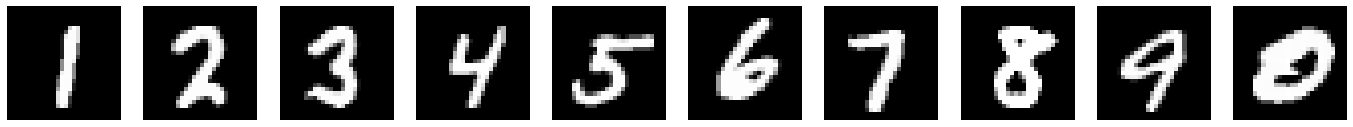

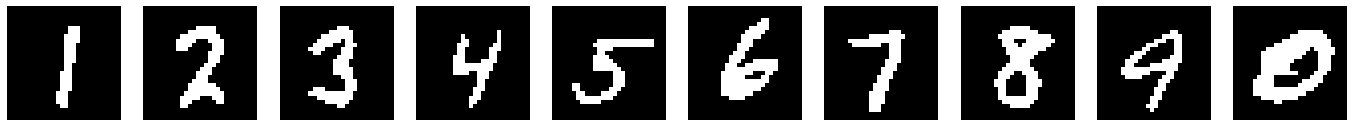

In [ ]:
# #Defense Accuracy
def binary_img(images) : 
    idx = images <0.75
    idx_2 = images >=0.75
    images[idx] =0
    images[idx_2] =1

    return images


model.eval()
model_B.eval()

correct = 0
total = 0

correct_B = 0
total_B = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()

    #compute accuracy on model A with defense
    ae_images_afterD = binary_img(images.clone())
    outputs = model(ae_images_afterD)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()



print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images_afterD[:10].detach())